In [1]:
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from functools import reduce

import YelpCleanData as cd # User Defined Fn
import Embedding_NN as nn # User Defined Fn

import warnings
warnings.simplefilter('ignore')

In [2]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [40]:
df_city_business = cd.load_data('data/city_business.csv')
df_city_review = cd.load_data('data/city_review.csv')
df_city_user = cd.load_data('data/city_user.csv')
# df_city_tip = cd.load_data('yelp_dataset/city_tip.csv')

In [4]:
thres_user_id = cd.select_index_with_thres(df_city_review, 'user_id', 20)
thres_buss_id = cd.select_index_with_thres(df_city_review, 'business_id', 20)
non_sparse_df = cd.filter_index(df_city_review, [['user_id',thres_user_id], ['business_id',thres_buss_id]])
user_business_df = cd.reset_index_cols(non_sparse_df, ['user_id','business_id','stars','date','text'])

In [5]:
user_business_df = user_business_df.merge(df_city_user[['user_id','review_count','average_stars']], on='user_id', how='left')
user_business_df = user_business_df.rename(columns={'review_count': 'user_review_count', 'average_stars': 'user_average_stars'})

user_business_df = user_business_df.merge(df_city_business[['business_id','review_count','stars','categories']], on='business_id', how='left')
user_business_df = user_business_df.rename(columns={'review_count': 'buss_review_count', 'stars_x':'stars', 'stars_y': 'buss_average_stars'})

In [6]:
train_df, test_df = cd.split_most_recent(user_business_df)
train_df, val_df = cd.split_most_recent(train_df)

In [7]:
test_df.shape, val_df.shape, train_df.shape

((4712, 10), (4712, 10), (231599, 10))

In [8]:
le_user = cd.generate_labelEncoder(user_business_df, 'user_id')
le_buss = cd.generate_labelEncoder(user_business_df, 'business_id')

user_train, buss_train = le_user.transform(train_df['user_id']), le_buss.transform(train_df['business_id'])
user_val, buss_val = le_user.transform(val_df['user_id']), le_buss.transform(val_df['business_id'])
user_test, buss_test = le_user.transform(test_df['user_id']), le_buss.transform(test_df['business_id'])

In [9]:
le_target = cd.generate_labelEncoder(user_business_df, 'stars')

train_y = le_target.transform(train_df['stars']).astype('float32')
test_y = le_target.transform(test_df['stars']).astype('float32')
val_y = le_target.transform(val_df['stars']).astype('float32')

In [10]:
user_cols = ['user_review_count','user_average_stars']
buss_cols = ['buss_review_count','buss_average_stars']

train_user_info, train_buss_info = cd.get_array_from_df(train_df, user_cols), cd.get_array_from_df(train_df, buss_cols)
val_user_info, val_buss_info = cd.get_array_from_df(val_df, user_cols), cd.get_array_from_df(val_df, buss_cols)
test_user_info, test_buss_info = cd.get_array_from_df(test_df, user_cols), cd.get_array_from_df(test_df, buss_cols)

In [11]:
temp_df = train_df.groupby(['user_id','business_id']).mean('stars').reset_index()
user_buss_pair = cd.melt_with_pivot(temp_df, 'user_id', 'business_id', 'stars')

assert user_buss_pair.shape[0] == len(train_df['user_id'].unique()) * len(train_df['business_id'].unique())

user_of_pair = le_user.transform(user_buss_pair['user_id'])
buss_of_pair = le_buss.transform(user_buss_pair['business_id'])

In [12]:
num_latent = 40
user_cnt, buss_cnt = len(train_df['user_id'].unique()), len(train_df['business_id'].unique()) 
model = nn.NN_model(num_latent, user_cnt, buss_cnt)

Metal device set to: Apple M1


2022-11-08 23:48:59.231227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-08 23:48:59.231348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 buss_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 40)        188480      ['user_input_layer[0][0]']       
                                                                                                  
 buss_embedding (Embedding)     (None, 1, 40)        176320      ['buss_input_layer[0][0]']       
                                                                                              

In [14]:
model.train_model([user_train, buss_train, train_y], [user_val, buss_val, val_y])

Epoch 1/15


2022-11-08 23:49:00.388400: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-08 23:49:00.870942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:49:25.337568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1810/1810 - 25s - loss: 1.6878 - root_mean_squared_error: 1.2991 - val_loss: 1.4815 - val_root_mean_squared_error: 1.2172 - 25s/epoch - 14ms/step
Epoch 2/15
1810/1810 - 21s - loss: 1.2344 - root_mean_squared_error: 1.1110 - val_loss: 1.4076 - val_root_mean_squared_error: 1.1864 - 21s/epoch - 11ms/step
Epoch 3/15
1810/1810 - 21s - loss: 1.1539 - root_mean_squared_error: 1.0742 - val_loss: 1.3736 - val_root_mean_squared_error: 1.1720 - 21s/epoch - 11ms/step
Epoch 4/15
1810/1810 - 20s - loss: 1.1099 - root_mean_squared_error: 1.0535 - val_loss: 1.3330 - val_root_mean_squared_error: 1.1546 - 20s/epoch - 11ms/step
Epoch 5/15
1810/1810 - 21s - loss: 1.0496 - root_mean_squared_error: 1.0245 - val_loss: 1.2671 - val_root_mean_squared_error: 1.1257 - 21s/epoch - 11ms/step
Epoch 6/15
1810/1810 - 21s - loss: 0.9784 - root_mean_squared_error: 0.9891 - val_loss: 1.2049 - val_root_mean_squared_error: 1.0977 - 21s/epoch - 11ms/step
Epoch 7/15
1810/1810 - 21s - loss: 0.9239 - root_mean_squared_error: 

In [18]:
pred = model.evaluate_model([user_test, buss_test])
print(np.sqrt(mean_squared_error(test_y, pred))) 

148/148 [==============================] - 0s 2ms/step
1.1258527


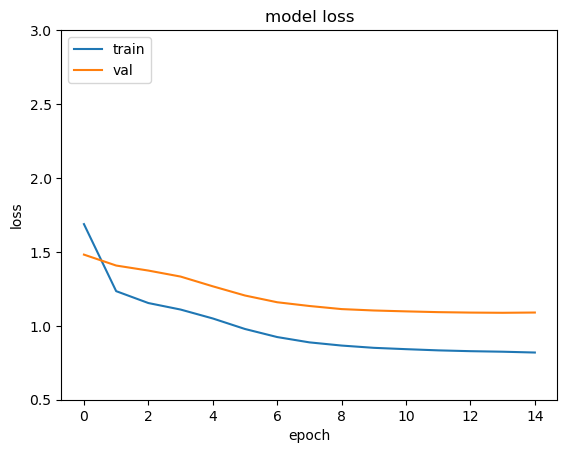

In [19]:
model.plot_learning_curve()

In [20]:
model.save_model('nn_model.m')

INFO:tensorflow:Assets written to: nn_model.m/assets
--model saved--


In [74]:
# Based on random number generation given current distribution of star ratings
total = np.bincount(test_y.astype('int64')).sum()
probs = np.bincount(test_y.astype('int64'))/total

cum = 0
n = 5000
for i in range(n):
    current = np.sqrt(mean_squared_error(test_y, np.random.choice(np.arange(1, 6), total, p=probs)))
    cum += current
print(cum/n) 

2.0363641368118857


In [24]:
pair_ratings = model.evaluate_model([user_of_pair, buss_of_pair], batch_size=8192)

2536/2536 [==============================] - 22s 8ms/step


In [25]:
# User_Business Matrix Based on prediction
all_pred_ratings = pd.DataFrame()
all_pred_ratings['user_id'] = le_user.inverse_transform(user_of_pair)
all_pred_ratings['business_id'] = le_buss.inverse_transform(buss_of_pair)
all_pred_ratings['stars'] = pair_ratings

In [26]:
all_pred_ratings.pivot(index='user_id', columns='business_id', values='stars')

business_id,-0TffRSXXIlBYVbb5AwfTg,-0eUa8TsXFFy0FCxHYmrjg,-1B9pP_CrRBJYPICE5WbRA,-1b2kNOowsPrPpBOK4lNkQ,-1yftDfgOUlxe_IACM5PFg,-2-ih3mE8KPyeKVIzpBfPQ,-32hOCwsuKd04WO-HQyYFg,-4dYswJy7SPcbcERvitmIg,-5Rah4ZvWsDu4oilUZxhtw,-6MEKOmFu6jckT3pruSxHg,...,zvixukO8M4PCmMMaZOldPg,zvvl3c1FO3O3BZdhusficA,zwTmOj4B_OVPMTMYijQiKg,zwd4dyQ5ovnjVojWfAuhMw,zwgBxmrmPBF6N2uRTUYXrQ,zxRmQ_FWVowh8rlzLCSURQ,zxYD-C8GDnwuWDYxfD0spg,zyMkbavgHASQtqVwaock9A,zz-fcqurtm77bZ_rVvo2Lw,zz3E7kmJI2r2JseE6LAnrw
user_id,,,,,,,,,,,,,,,,,,,,,
-2cKJFFNJ9XVyWBt62mWvA,3.472694,3.227277,3.211500,3.777369,3.714596,3.049754,2.542150,2.445535,3.157865,2.197240,...,3.514961,3.213492,3.089887,3.251681,3.005603,3.133702,2.866905,3.097089,3.446674,3.140532
-4qa2JVDEC_QPVWcZ1nHkQ,2.717673,2.171474,2.168674,3.166579,2.908484,1.885896,1.502249,1.304322,2.302442,1.221160,...,2.694815,1.997829,1.999557,2.179667,1.944915,2.146857,1.488958,2.066591,2.592643,2.163406
-6GY04bTPM2Zo4z0GN4a1A,3.389313,3.075359,3.004156,3.732126,3.700672,2.850143,2.274295,1.786982,2.971826,1.508585,...,3.481878,2.974375,3.029625,3.077513,2.695929,2.984381,2.453882,2.889805,3.464159,3.028604
-7-d8x5w5c9QolAMgPTKZg,3.184964,2.696399,2.679344,3.656222,3.487114,2.706046,2.058348,1.674227,2.943555,1.496938,...,3.319039,2.753958,2.755467,2.803247,2.556925,2.683315,2.223989,2.487304,3.242423,2.693631
-9OIms4jE1bdD1fz7AzAFA,3.210359,2.930842,2.742733,3.533287,3.554738,2.571988,2.157937,1.778168,2.847281,1.611569,...,3.356415,2.800843,2.762117,2.814208,2.511161,2.756599,2.199080,2.723851,3.296446,2.727063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zu-e06_BM_TdkAZEKMrIww,3.245445,2.996927,2.990448,3.492259,3.532800,2.679392,2.174237,1.635951,2.914876,1.457610,...,3.337458,2.892961,2.762658,3.049937,2.442831,2.700537,2.079136,2.735316,3.218271,2.756453
zvHe_sQhUk6vxE_svqh9DA,3.067585,2.696642,2.443876,3.555547,3.453867,2.556263,1.911402,1.536875,2.700952,1.383921,...,3.284362,2.591556,2.698984,2.790121,2.289445,2.479389,2.041756,2.548951,3.135949,2.504476
zvq6qxc2IVA08jaUelUMRw,3.161628,2.687902,2.661587,3.491297,3.467177,2.543202,2.137325,1.579147,2.728395,1.464081,...,3.314235,2.615705,2.594318,2.822109,2.298899,2.529621,2.207712,2.577649,3.193015,2.613368


In [35]:
print('---------Predict----------')
print(all_pred_ratings['stars'].describe())
print('---------Original---------')
print(user_business_df['stars'].describe())

---------Predict----------
count    2.077050e+07
mean     2.748523e+00
std      6.456288e-01
min      1.007167e+00
25%      2.328238e+00
50%      2.853600e+00
75%      3.246753e+00
max      4.559938e+00
Name: stars, dtype: float64
---------Original---------
count    241023.000000
mean          3.858748
std           1.075997
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64


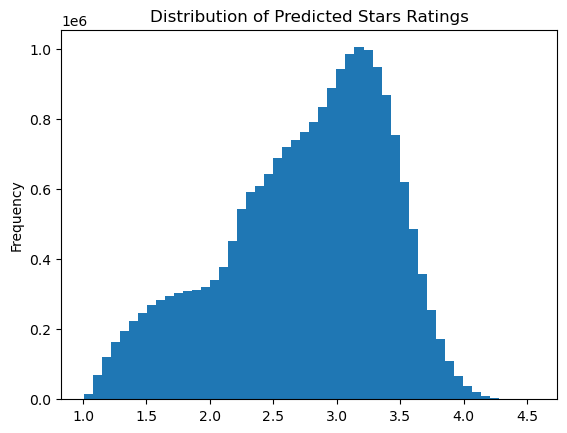

In [28]:
all_pred_ratings['stars'].plot.hist(bins=50)
plt.title('Distribution of Predicted Stars Ratings')
plt.show()

# Extract Users who are predicted to give positive ratings or negative

In [52]:
# Extract Users who are predicted to give positive ratings or negative
# Top 1% positive ratings or negative
review_nums = int(all_pred_ratings.shape[0]*0.01)
stars_sorted_df = all_pred_ratings.sort_values(by=['stars'])
high_df, low_df = stars_sorted_df[-review_nums:], stars_sorted_df[:review_nums]

In [58]:
# Save
high_df.to_csv('data/high_ratings.csv', index=False)
low_df.to_csv('data/low_ratings.csv', index=False)
user_business_df.to_csv('data/rating_history.csv', index=False)